In [56]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
import re
from sklearn import preprocessing
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 250

sys.path.append('../')
import read_player_stats
import training_data

In [57]:
#change position and adjust parameters for sheet here
position = 'te'

#parameters for positions
pages = {'qb': [0,1], 'rb': [0,1,2,3], 'wr': [0,1,2,3], 'te': [0,1]}
starters = {'qb': 12, 'rb': 30, 'wr': 42, 'te': 12}
n_clusters = {'qb': 3, 'rb': 3, 'wr': 4, 'te': 3}

#read in data and make training samples
total_df = training_data.make_total_data(seasons=range(2004,2015), pages=pages[position], pos=position)
train_df = training_data.make_training_df(total_df, seasons=range(2004,2014), ppg=True)

In [58]:
#ADP Table
ADP_df = pd.read_csv('../projections/2015_ADP.csv')
#rename the columns and drop the irrelevant ones
ADP_df.columns = ['ADP', 'Name', 'Position', 'Team', 'Bye', 'MFL', 'FFC', 'RTS', 'Fantrax', 'NNN']
ADP_df.drop(['ADP', 'Position', 'Team', 'NNN'], axis=1, inplace=True)
#fix the names to match other data
ADP_df['Name'] = ADP_df['Name'].str.replace('[^a-z]', '',flags=re.IGNORECASE)

In [59]:
#model
model = training_data.train_player_model(train_df)
#data for 2015 projections
most_rec = training_data.data_for_projection(total_df, season=2015)

proj = training_data.ff_projection(most_rec, model)
baseline = proj.loc[starters[position], '2015 Projection']

In [60]:
#calculate values relative to last likely starter
base_sub = proj['2015 Projection'] - baseline
proj['Value Above Baseline'] = base_sub
proj.head()

,Name,2015 Projection,Value Above Baseline
1,JimmyGraham,15.046483,6.460160
2,RobGronkowski,14.061922,5.475598
3,GregOlsen,12.514160,3.927837
4,MartellusBennett,11.457613,2.871289
5,JuliusThomas,11.352958,2.766635


Group 0
mean: 10.8578947368
std: 3.82992590137
Group 1
mean: 6.16022727273
std: 3.27174681494
Group 2
mean: 2.99496124031
std: 2.52539309214


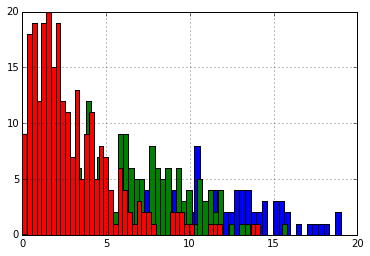

In [61]:
#clusters
clust, model = training_data.cluster_players(train_df, n_clusters=n_clusters[position])

In [62]:
#Get groups for
X_pred = np.array(most_rec.drop(['Name', '2015 Projection'], axis=1))
X_pred = preprocessing.scale(X_pred)
y_pred = model.predict(X_pred)

In [63]:
most_rec['Group'] = y_pred

In [64]:
summary_table = pd.merge(proj, most_rec[['Name', 'Group']], on='Name', how='inner')
summary_table = pd.merge(summary_table, ADP_df, on='Name', how='inner')

In [65]:
summary_table

,Name,2015 Projection,Value Above Baseline,Group,Bye,MFL,FFC,RTS,Fantrax
0,JimmyGraham,15.046483,6.460160,0,9,32,33,29,25
1,RobGronkowski,14.061922,5.475598,0,4,6,14,8,11
2,GregOlsen,12.514160,3.927837,0,5,61,51,54,61
3,MartellusBennett,11.457613,2.871289,0,7,77,67,68,62
4,JuliusThomas,11.352958,2.766635,0,8,88,89,103,65
5,AntonioGates,11.294143,2.707819,0,10,132,146,143,161
6,DelanieWalker,11.087186,2.500863,0,4,119,115,111,124
7,JasonWitten,10.488086,1.901763,0,6,118,100,110,76
8,CobyFleener,9.702871,1.116548,0,10,162,NaN,125,134
9,CharlesClay,9.281677,0.695353,0,8,176,NaN,206,208


In [66]:
file_name = '../projections/' + position + '_summary_table.csv'
summary_table.to_csv(file_name)